## Recurrent Neural Network in Fake Data


### Importing Libraries

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive 
from oauth2client.client import GoogleCredentials

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, Activation
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
from ipywidgets import interact
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Loading dataset

In [ ]:
#read a '.csv' file into data-frame

df = pd.read_csv('gdrive/MyDrive/text_pre_processing.csv', sep=',')

df.sample(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
4699,4699,4699,Hillary Brands Bigoted Trump Supporters With ...,Democratic presidential nominee Hillary Clinto...,News,2016-09-10,fake,12,"['Democratic', 'presidential', 'nominee', 'Hil...",[],democratic presidential nominee hillary clinto...,[],[],hillary brands bigoted trump supporters with b...,"['democratic', 'presidential', 'nominee', 'hil...","['hillary', 'brands', 'bigoted', 'trump', 'sup..."
8049,8049,8049,"I Let A Pit Bull Near My Baby, And This Is Wh...",This is a two-year-old American Pit Bull Terri...,News,2016-02-17,fake,19,"['This', 'is', 'a', 'two', 'year', 'old', 'Ame...",['connect.facebook.net/en_US/all.js#xfbml=1'],this is a two-year-old american pit bull terri...,[],[],"i let a pit bull near my baby, and this is wha...","['this', 'is', 'two-year-old', 'american', 'pi...","['i', 'let', 'pit', 'bull', 'near', 'my', 'bab..."
31588,31588,31594,Japan PM welcomes U.S. designation of North Ko...,TOKYO (Reuters) - Japanese Prime Minister Shin...,worldnews,2017-11-20,true,8,"['TOKYO', '(Reuters)', 'Japanese', 'Prime', 'M...",[],TOKYO - japanese prime minister shinzo abe o...,[],[],japan PM welcomes U.S. designation of north ko...,"['TOKYO', 'japanese', 'prime', 'minister', 'sh...","['japan', 'PM', 'welcomes', 'U.S.', 'designati..."
36716,36716,36722,Leaked memo fuels accusations of ethnic bias i...,KABUL (Reuters) - A leaked memo from an staff ...,worldnews,2017-09-21,True,2,"['KABUL', '(Reuters)', 'A', 'leaked', 'memo', ...",[],KABUL - a leaked memo from an staff member i...,[],[],leaked memo fuels accusations of ethnic bias i...,"['KABUL', 'leaked', 'memo', 'from', 'an', 'sta...","['leaked', 'memo', 'fuels', 'accusations', 'of..."
8585,8585,8585,The Academy Just Showed The GOP How Diversity...,The Academy Of Motion Picture Arts And Science...,News,2016-01-22,fake,18,"['The', 'Academy', 'Of', 'Motion', 'Picture', ...",[],the academy of motion picture arts and science...,[],[],the academy just showed the GOP how diversity ...,"['the', 'academy', 'of', 'motion', 'picture', ...","['the', 'academy', 'just', 'showed', 'the', 'G..."


### Splitting Dataset Procedure

---
We split the data in 3 smaller datasets:
* Training, validation and test datasets



In [ ]:
#the column 'clean_text' is the one we want to split
X = df['clean_text'].reset_index(drop=True)

X.sample(10)

24740    LOS ANGELES/NEW YORK   - officials in new york...
38107    DHAKA   - bangladesh lodged a protest after it...
9929     leftist activist and mediocre filmmaker michae...
19036    WASHINGTON   - U.S. president donald trump and...
34894    ((this story contains obscene language in the ...
4281     at the second presidential debate, donald trum...
3295     rachel maddow just pounded kellyanne conway, d...
2915     donald trump has been bragging about his inaug...
8724     if there s one thing that conservatives and fo...
27781    NEW YORK   - some  .  million americans watche...
Name: clean_text, dtype: object

In [ ]:
y = df['label'].to_frame()

y.sample(10)

,label
12076,fake
6328,fake
5682,fake
35183,True
27532,true
30336,true
21582,true
5420,fake
8883,fake
32826,True


In [ ]:
y[y['label'] == True] = 'true'
y = y.squeeze() #covert to data frame
y

0        fake
1        fake
2        fake
3        fake
4        fake
         ... 
38633    true
38634    true
38635    true
38636    true
38637    true
Name: label, Length: 38638, dtype: object

---
At first, we will split the main dataset into two parts:
* Train-Validation dataset and
* Test dataset (25% of the whole dataset)

After that, we will split the Train-Validation dataset into another two:
* Train dataset and
* Validation dataset (15% of the train-validation dataset)

This splitting has been done in stratified manner, meaning that the dataset has been split uniformly based on the percentage of 'fake' - 'true' news.

In [ ]:
#sss: stratified shuffle split
test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.25,
            train_size=None)

In [ ]:
val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15,
            train_size=None)

In [ ]:
#split in train-validation dataset and test dataset
X_train_val, X_test, y_train_val, y_test = None, None, None, None

#get the indexes for each dataset
for train_index, test_index in test_sss.split(X, y):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

TRAIN-VAL: [22033 10814  8803 11309 26936 27847  4873  7727 20681 11339] TEST: [35872 38335 20464 32126  8698 12391 28753   145 15427 23566]
TRAIN-VAL: [31419 32366  2163 20173 32013 12531 35254 12308 18870 32123] TEST: [ 5362 23644 31270 11417 20018 31629 33623 34934  4858  3667]
TRAIN-VAL: [37017 21858 27556 26992 15331  7244 28496  9024 17132 20787] TEST: [36063 25352   990  4780 23669 17533  9029 20777 25330 14106]
TRAIN-VAL: [ 3136 13433 17381 19237  3151 28199  6094 19151 33372   968] TEST: [ 1769 26284 28168 20047 31449 28233 25473 29949 24160 16172]
TRAIN-VAL: [16042  6117 32481 33043 19496 19840  5078 28837 30784   971] TEST: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]


In [ ]:
X_train_val.head() #show the first 5 indexes

16042    can you believe a first grader was investigate...
6117     there should be no doubt that racism is very m...
32481    BEIRUT   - hezbollah s parliamentary bloc call...
33043    SEOUL/WASHINGTON   - two U.S. strategic bomber...
19496      - the wife of U.S. treasury secretary steve ...
Name: clean_text, dtype: object

In [ ]:
#reset the indexes
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

In [ ]:
#split the train-validation dataset into train and validation dataset
X_train, X_val, y_train, y_val = None, None, None, None

for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

TRAIN: [16622 27701 25079 28089 21477 11662  8228 14396  5133 26223] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]
TRAIN: [ 7622  6949 15797  6652 16246 16534 19690 11268 28871 21944] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]
TRAIN: [16548 26162 16257 12055  5336  5928 10012 14887 17351  6124] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]
TRAIN: [11278  5654 15952 23752 26907 15079 28130 16321 24645  4279] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]
TRAIN: [11639 14247 14867  3939 12279 12830 16613  8407 19602 27713] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]


In [ ]:
#see the final results
print('X_train_val shape: {}'.format(X_train_val.shape))
print('y_train_val shape: {}'.format(y_train_val.shape))
print()

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

print()
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

X_train_val shape: (28978,)
y_train_val shape: (28978,)

X_train shape: (24631,)
y_train shape: (24631,)

X_test shape: (9660,)
y_test shape: (9660,)

X_val shape: (4347,)
y_val shape: (4347,)


### Label Encoding 

We use label encoder instead of one-hot, because we want to have only one class in the end in order to insert it in the Feed Forward NN.

In [ ]:
#encoding the labels using Label Encoder
y_lab = LabelEncoder()

In [ ]:
y_train_lab = y_lab.fit_transform(y_train)
y_train_lab

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
y_test_lab = y_lab.transform(y_test)
y_val_lab = y_lab.transform(y_val)

In [ ]:
#print their format
print('y_train shape: {}'.format(y_train_lab.shape))
print('y_test shape: {}'.format(y_test_lab.shape))
print('y_val shape: {}'.format(y_val_lab.shape))

y_train shape: (24631,)
y_test shape: (9660,)
y_val shape: (4347,)


In [ ]:
#the final classes from the encoder
y_lab.classes_

array(['fake', 'true'], dtype=object)

### Word Embeddings

In [ ]:
max_words = 15_000  #we will only take the 15K most used words in the whole news dataset

#initialize the Keras tokenizer
reviews_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
reviews_tokenizer.fit_on_texts(X_train)

In [ ]:
reviews_tokenizerTest = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
reviews_tokenizerTest.fit_on_texts(X_test)

In [ ]:
reviews_tokenizerVal = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
reviews_tokenizerVal.fit_on_texts(X_val)

In [ ]:
xtrain_seq = reviews_tokenizer.texts_to_sequences(X_train)
xtest_seq = reviews_tokenizerTest.texts_to_sequences(X_test)
xval_seq = reviews_tokenizerVal.texts_to_sequences(X_val)

* In order to continue, we have to make sure that all the sentences that will be used in our model will have the same length. So, we use the `Keras pad sequences tool`. This tool, cuts those sentences that are too big and for those that are too small adds zeros. 

Here, we make all the sentences to have length 401 words (the average words of each sentence).

In [ ]:
import statistics
seq_len = [len(i.split()) for i in X_train_val]
MAX_LENGHT = int(statistics.mean(seq_len))
print(MAX_LENGHT)

401


In [ ]:
xtrain_pad = pad_sequences(xtrain_seq, maxlen=MAX_LENGHT)
xtest_pad = pad_sequences(xtest_seq, maxlen=MAX_LENGHT)
xval_pad = pad_sequences(xval_seq, maxlen=MAX_LENGHT) #create embedding (words into sequence of numbers)

In [ ]:
word_index = reviews_tokenizer.word_index

* Build the vocabulary from the text taken in [Kaggle](https://www.kaggle.com/thanakomsn/glove6b300dtxt?select=glove.6B.300d.txt)

In [ ]:
embedding_vectors = {}
with open('gdrive/MyDrive/glove.6B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}") 

Size of vocabulary in GloVe: 400000


In [ ]:
#initialize the embedding_matrix with zeros
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)

#### Model Setup

In [ ]:
print('Building model...', end='\n\n')

#initialize an empty sequential structure, meaning that each layer we add, its output will be added as input in the next layer 
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))

#add a dense layer (multi layer perception - MLP) and use relu activation on MLP's outputs
lstm_model.add(Dense(512, activation = 'relu'))

#use a dropout layer with with 40% of inputs dropped
lstm_model.add(Dropout(0.4))

#add a dense layer (MLP) and use sigmoid activation on MLP's outputs
lstm_model.add(Dense(1, activation = 'sigmoid'))

#compiling the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Building model...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         4500000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 4,786,209
Trainable params: 286,209
Non-trainable params: 4,500,000
_________________________________________________________________
None


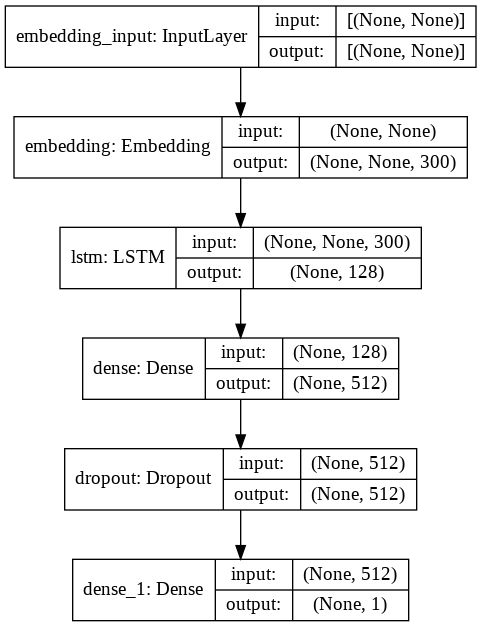

In [ ]:
plot_model(lstm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training the Recurrent Network Model

In [ ]:
monitor = 'val_loss'

callbacks = [   
    #stop the training when a monitored quantity has stopped improving
    EarlyStopping(monitor=monitor, patience=7, verbose=1, restore_best_weights=True),
             
    #Reduce learning rate is called when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1)]

In [ ]:
batch_size = 64
epochs  = 30
history = lstm_model.fit(xtrain_pad, 
                         y_train_lab, 
                         validation_data=(xtest_pad, y_test_lab), 
                         batch_size = batch_size, 
                         epochs = epochs,
                         verbose=2,
                         callbacks = callbacks)

Epoch 1/30
385/385 - 421s - loss: 0.1582 - accuracy: 0.9416 - val_loss: 1.1326 - val_accuracy: 0.6679
Epoch 2/30
385/385 - 423s - loss: 0.0691 - accuracy: 0.9784 - val_loss: 0.7718 - val_accuracy: 0.6697
Epoch 3/30
385/385 - 424s - loss: 0.0640 - accuracy: 0.9788 - val_loss: 0.9949 - val_accuracy: 0.7032
Epoch 4/30
385/385 - 420s - loss: 0.0442 - accuracy: 0.9858 - val_loss: 0.7947 - val_accuracy: 0.7568
Epoch 5/30
385/385 - 423s - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.7030 - val_accuracy: 0.7902
Epoch 6/30
385/385 - 423s - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.7997 - val_accuracy: 0.7463
Epoch 7/30
385/385 - 421s - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.7620 - val_accuracy: 0.7857
Epoch 8/30
385/385 - 424s - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.8862 - val_accuracy: 0.7908
Epoch 9/30
385/385 - 422s - loss: 0.0040 - accuracy: 0.9989 - val_loss: 1.2036 - val_accuracy: 0.7777
Epoch 10/30
385/385 - 421s - loss: 0.0058 - accuracy: 0.9983 - val_loss: 1.4476 - 

In [ ]:
lstm_model.save #save the model for later use

<bound method Model.save of <keras.engine.sequential.Sequential object at 0x7f6431835590>>

In [ ]:
def plot_keras_history(history):
    """    
    :param history: 
    :return: 
    """ 
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        if i == 2:
          break
        else:
          #getting the training values
          metric_train_values = history.history.get(metric, [])
          
          #getting the validation values
          metric_val_values = history.history.get("val_{}".format(metric), [])

          epochs = range(1, len(metric_train_values) + 1)
          
          #leaving extra spaces to allign with the validation text
          training_text = "   Training {}: {:.5f}".format(metric,
                                                          metric_train_values[-1])

          #metric
          plt.figure(i, figsize=(12, 6))
          plt.plot(epochs, metric_train_values, 'b', label=training_text)
          
          #if the validation metric exists, then plot that as well
          if metric_val_values:
              validation_text = "Validation {}: {:.5f}".format(metric,
                                                              metric_val_values[-1])

              plt.plot(epochs, metric_val_values, 'g', label=validation_text)
          
          #add title, xlabel, ylabel, and legend
          plt.title('Model Metric: {}'.format(metric))
          plt.xlabel('Epochs')
          plt.ylabel(metric.title())
          plt.legend()

    plt.show()

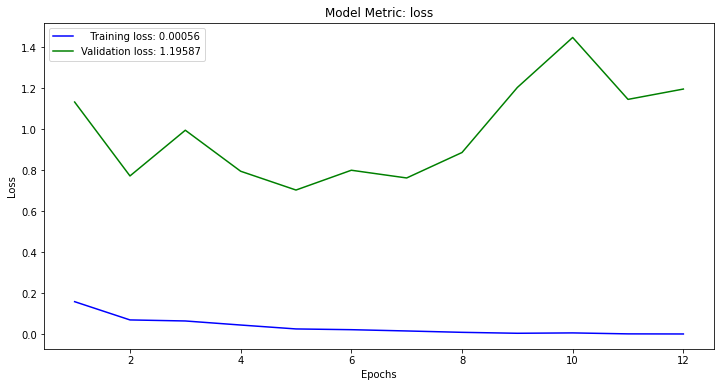

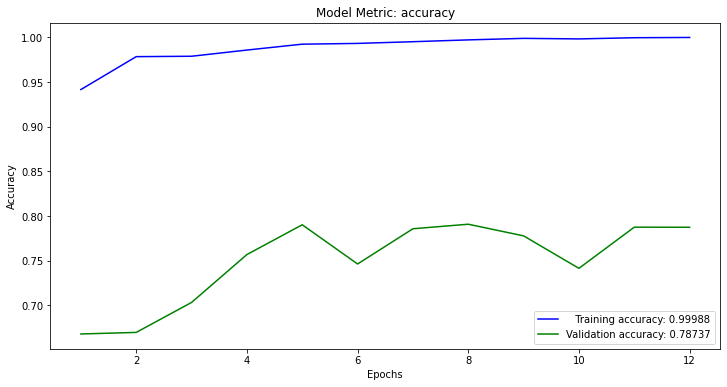

In [ ]:
plot_keras_history(history)

### Model Evaluation

In [ ]:
#evaluate and store on score variable the test dataset
score = lstm_model.evaluate(
    xval_pad,    
    y_val_lab,             
    batch_size=batch_size,   
    verbose=2)

68/68 - 24s - loss: 1.2156 - accuracy: 0.6533


In [ ]:
print('\nTest binary_crossentropy: {:.4f}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 1.2156

Test accuracy: 65.332 %


### Model Prediction 

In [ ]:
#get the probabilities for each news
y_val_pred_probs = lstm_model.predict(xval_pad)
y_val_pred_probs[:20]

array([[1.61146939e-01],
       [9.99639153e-01],
       [1.53818727e-02],
       [5.12799025e-02],
       [9.42060888e-01],
       [9.47427154e-02],
       [9.99784648e-01],
       [3.19471657e-02],
       [3.15368176e-04],
       [8.91368389e-02],
       [9.89872098e-01],
       [8.38348269e-03],
       [9.90683794e-01],
       [9.99870181e-01],
       [8.38184357e-03],
       [1.18275136e-01],
       [2.75788009e-02],
       [6.43746257e-02],
       [1.13067627e-02],
       [3.99611056e-01]], dtype=float32)

In [ ]:
#show the class they belong
y_val_preds = (y_val_pred_probs >= 0.5).astype('int64')

y_val_preds[:10]

array([[0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0]])

* Let's see some evaluation metrics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [ ]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_val_lab, y_pred=y_val_preds)
pd.DataFrame(conf_mat, columns = y_lab.classes_, index= y_lab.classes_)

,fake,true
fake,1487,476
true,1031,1353


In [ ]:
#classification report
print(classification_report(y_true=y_val_lab, y_pred=y_val_preds))

              precision    recall  f1-score   support

           0       0.59      0.76      0.66      1963
           1       0.74      0.57      0.64      2384

    accuracy                           0.65      4347
   macro avg       0.67      0.66      0.65      4347
weighted avg       0.67      0.65      0.65      4347



In [ ]:
def plot_binary_class_row_auc(y_true,
                              clf_names: list,
                              clfs_preds: list):
    """

    :param y_true: The true labels in label encoding
    :param clf_names: The names of the classifiers in order to plot
    :param clfs_preds: A list of numpy arrays, that contain predictions from various classifiers
    :return:
    """
    assert len(clf_names) == len(clfs_preds)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds)

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)
    plt.plot([0, 1],
             [0, 1],
             'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds)

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()

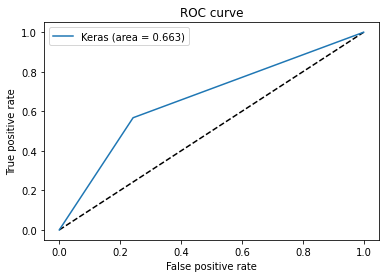

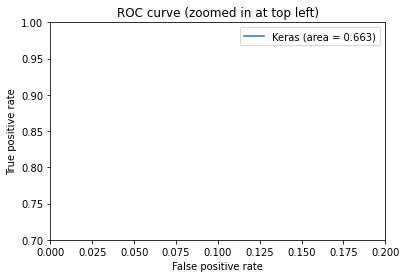

In [ ]:
#ROC curve
plot_binary_class_row_auc(y_true=y_val_lab,
                          clf_names=['Keras'],
                          clfs_preds=[y_val_preds.ravel()])

In [ ]:
print(roc_auc_score(y_val_lab, y_val_preds))

0.662523783108309


In [ ]:
#save the weights of the model
lstm_model.save_weights('RNN.h5')

Here is an example. We are giving a text in the model and it returns to us how much fake it is.

In [ ]:
X_val.iloc[1943,]

'OOPS! IN   BILL CLINTON SAID THE SAME THING MAKE AMERICA GREAT AGAIN :'

In [ ]:
df[df['clean_text'] == X_val.iloc[1943,]]

,Unnamed: 0,Unnamed: 0.1,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
12690,12690,12691,IRONIC: WHITE SOUTHERNER BILL CLINTON Just Tol...,OOPS! IN 2008 BILL CLINTON SAID THE SAME THING...,politics,2016-09-09,fake,41,"['OOPS', 'IN', '2008', 'BILL', 'CLINTON', 'SAI...",[],OOPS! IN BILL CLINTON SAID THE SAME THING MA...,[],[],IRONIC: WHITE SOUTHERNER BILL CLINTON just tol...,"['OOPS', '!', 'IN', 'BILL', 'CLINTON', 'SAID',...","['IRONIC', 'WHITE', 'SOUTHERNER', 'BILL', 'CLI..."


In [ ]:
# Demo on a fake text
my_text = df.iloc[12690,3] #the index

seq = reviews_tokenizer.texts_to_sequences([my_text])
print('raw seq:', seq)

seq = pad_sequences(seq, maxlen=MAX_LENGHT)
print('padded seq:', seq)

prediction = lstm_model.predict(seq)
print('truthfullness:', prediction)

raw seq: [[12293, 7, 1, 161, 78, 13, 2, 245, 412, 135, 183, 375, 298]]
padded seq: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    

---
#### **Conclusions**

From the above evaluation metrics we can assume that this model performs not as good as it was expected. Actually, it  fits somehow bad on our data. More specifically,


1.   **Binary Crossentropy Loss function**: gives us on training and on validation sets about 1.2 loss.
2.   **Accuracy**: almost 79% in training set and nearly 65% on validation set
3.   **Confusion Matrix**: From the 1963 false news the 476 predicted falsefully as true and from the 2384 true news about half of them (1353) predicted as fake.
4.    **Classification Report**: Mediocre values can also be observed in the above classification report (from 57% to 76%).
5.    **ROC Curve**: Combined the above plot and its score (66.25%) we can finally conclude that the ratio of true positive to false positive has medium value.

Although these evaluation metrics were medium, the demo example found the category of the news, where we can see that one random fake news gives a really small number of *'truthfullness'*.